In [102]:
import pandas as pd
import re
import spacy
import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

# Cargar modelo spaCy
nlp = spacy.load("es_core_news_sm")
modelo = ["GPT-4o-mini", "llama-3.1-8b-instant", "gemma2-9b-it"]

# Cargar datos
df = pd.read_excel("../datos/Clasificación_GPT-4o-mini-Completo.xlsx")
texts = df["Raw_GPT-4o-mini_Chain_Of_Thought"].dropna().astype(str).tolist()
polaridad = df["Polarity_GPT-4o-mini_Chain_Of_Thought"].dropna().astype(str).tolist()
polaridad_True = df["Polarity"].dropna().astype(str).tolist()

In [103]:
def traducir_emojis(texto):
    texto = emoji.demojize(texto, language="es")
    texto = texto.replace(":", " ").replace("_", " ")
    return texto

def limpiar_y_lematizar(texto):
    texto = texto.lower()  # minúsculas
    texto = traducir_emojis(texto)  # traducir emojis
    texto = re.sub(r"1\. identificación de palabras clave.*?2\. interpretación del tono general[:]*", '', texto, flags=re.IGNORECASE | re.DOTALL)
    texto = re.sub(r"detección de matices[:]*", '', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)  # quitar URLs
    texto = re.sub(r"@\w+", '', texto)  # quitar menciones
    texto = re.sub(r"#\w+", '', texto)  # quitar hashtags
    texto = re.sub(r"[^\w\sáéíóúüñ]", '', texto)  # quitar signos raros y puntuación
    doc = nlp(texto)  # procesar con spaCy para lematizar
    lemas = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(lemas)

texts_procesados = [limpiar_y_lematizar(t) for t in texts]

In [104]:
df_polaridad = pd.DataFrame({  ## Crear DataFrame con polaridad y textos procesados
    "texto": texts_procesados,
    "polaridad": polaridad
})

df_polaridad_true = pd.DataFrame({  ## Crear DataFrame con polaridad verdadera y textos procesados
    "texto": texts_procesados,
    "polaridad": polaridad_True
})

grupos = df_polaridad.groupby("polaridad")["texto"].apply(lambda x: " ".join(x))
grupos_true = df_polaridad_true.groupby("polaridad")["texto"].apply(lambda x: " ".join(x))


In [105]:
vectorizer = CountVectorizer(max_features=30)
vectorizer_tfidf = TfidfVectorizer(max_features=30)
vectorizer_pol = TfidfVectorizer(max_features=30)


Xbow = vectorizer.fit_transform(texts_procesados)
Xtfidf = vectorizer_tfidf.fit_transform(texts_procesados)
X_polaridades = vectorizer_pol.fit_transform(grupos)
X_polaridades_true = vectorizer_pol.fit_transform(grupos_true)

df_bow = pd.DataFrame(Xbow.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf = pd.DataFrame(Xtfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out())
df_tfidf_polar = pd.DataFrame(X_polaridades.toarray(), index=grupos.index, columns=vectorizer_pol.get_feature_names_out())
df_tfidf_polar_true = pd.DataFrame(X_polaridades_true.toarray(), index=grupos_true.index, columns=vectorizer_pol.get_feature_names_out())

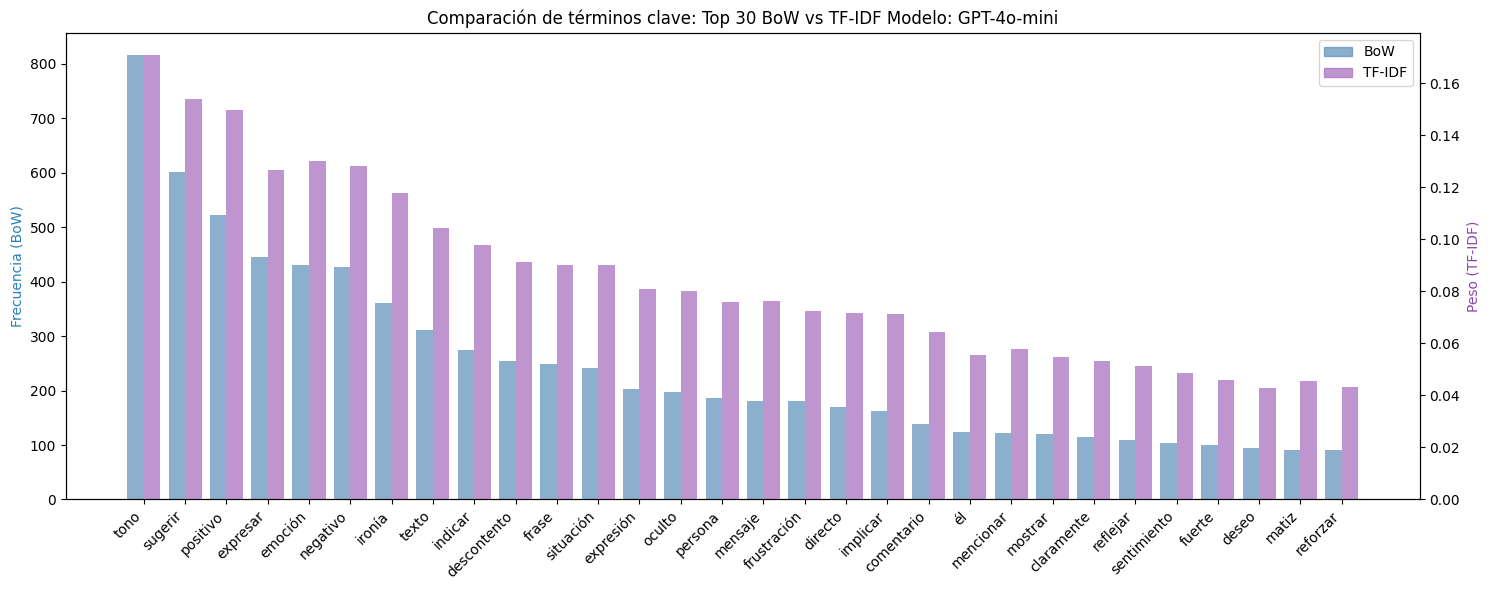

In [106]:
# Selecciona las 20 palabras más frecuentes según BoW
palabras_top20 = frecuencias.head(30).index.tolist()
frecuencias_bow = frecuencias.head(30).values
pesos_tfidf = df_tfidf_prom.set_index("palabra").loc[palabras_top20, "tfidf"].values

x = np.arange(len(palabras_top20))
width = 0.4

fig, ax1 = plt.subplots(figsize=(15, 6))
bars1 = ax1.bar(
    x - width/2, frecuencias_bow, width, 
    label='BoW', color='#5B8DB8', alpha=0.7  # azul más opaco
)
ax1.set_ylabel('Frecuencia (BoW)', color='#2980b9')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(x)
ax1.set_xticklabels(palabras_top20, rotation=45, ha='right')

ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2, pesos_tfidf, width, 
    label='TF-IDF', color='#A569BD', alpha=0.7  # morado más opaco
)
ax2.set_ylabel('Peso (TF-IDF)', color='#8e44ad')
ax2.tick_params(axis='y', labelcolor='black')

# Crear leyenda combinada
handles = [
    plt.Rectangle((0,0),1,1, color='#5B8DB8', alpha=0.7, label='BoW'),
    plt.Rectangle((0,0),1,1, color='#A569BD', alpha=0.7, label='TF-IDF')
]
ax1.legend(handles=handles, loc='upper right')

plt.title(f'Comparación de términos clave: Top 30 BoW vs TF-IDF Modelo: {modelo[0]}')
plt.tight_layout()
plt.show()


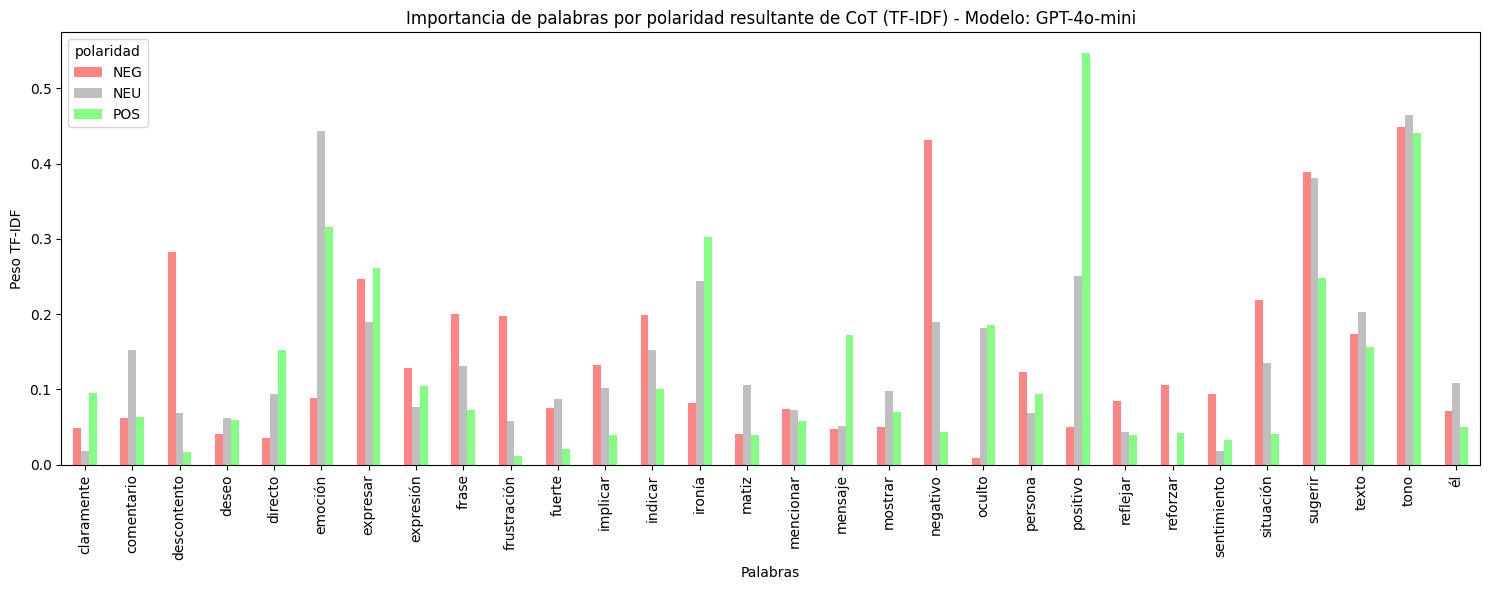

In [109]:
colores = ["#FF6666", "#B0B0B0", "#66FF66"]  # NEG rojo pastel oscuro, NEU gris, POS verde pastel oscuro (más visibles)
df_tfidf_polar.T.plot(kind="bar", figsize=(15,6), color=colores, alpha=0.8)
plt.title(f"Importancia de palabras por polaridad resultante de CoT (TF-IDF) - Modelo: {modelo[0]}")
plt.xlabel("Palabras")
plt.ylabel("Peso TF-IDF")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

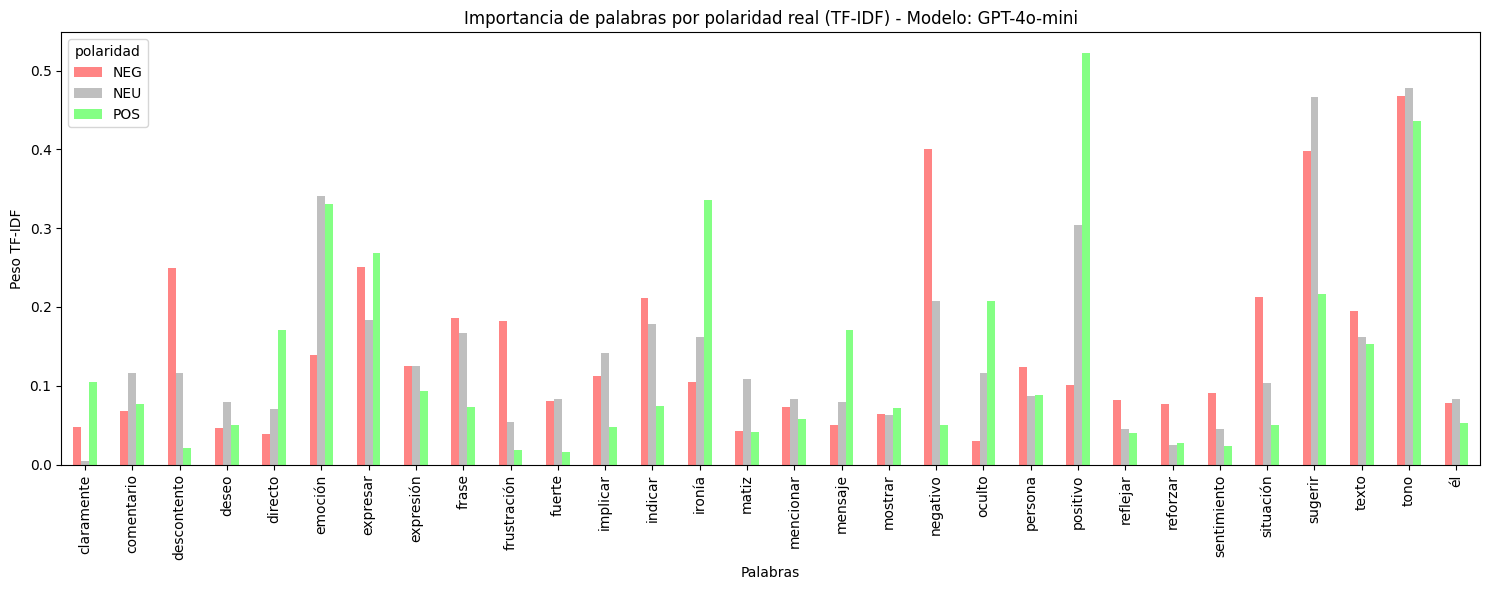

In [110]:
colores = ["#FF6666", "#B0B0B0", "#66FF66"]
df_tfidf_polar_true.T.plot(kind="bar", figsize=(15,6), color=colores , alpha=0.8)
plt.title(f"Importancia de palabras por polaridad real (TF-IDF) - Modelo: {modelo[0]}")
plt.xlabel("Palabras")
plt.ylabel("Peso TF-IDF")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

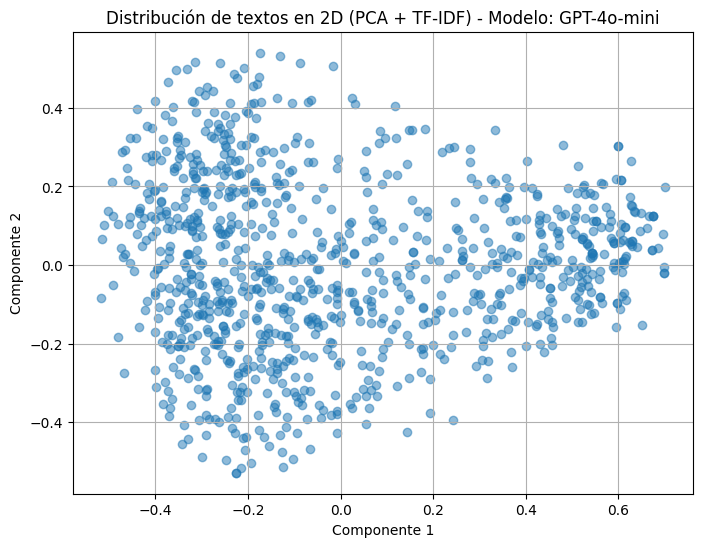

In [116]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xtfidf.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title(f"Distribución de textos en 2D (PCA + TF-IDF) - Modelo: {modelo[0]}")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

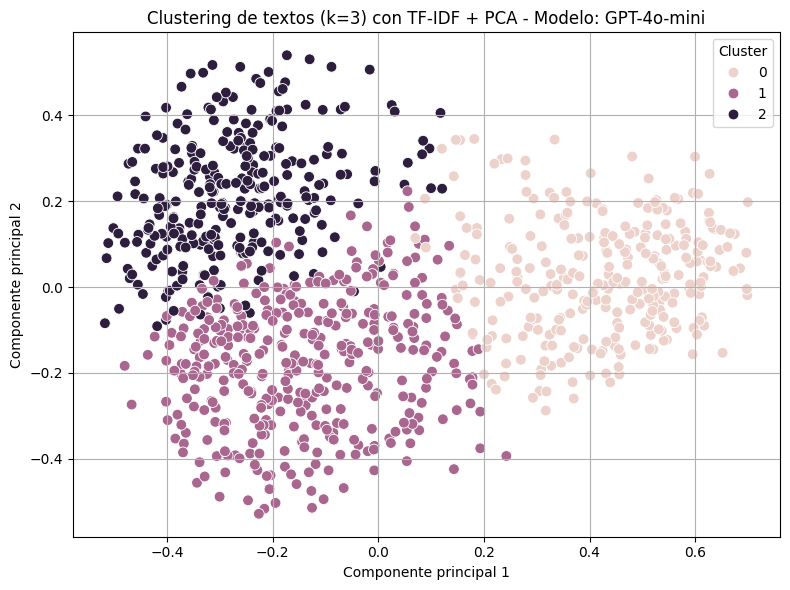

In [117]:
k = 3  #numero clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(Xtfidf)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xtfidf.toarray())

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, s=60)
plt.title(f"Clustering de textos (k={k}) con TF-IDF + PCA - Modelo: {modelo[0]}")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [118]:
df["Cluster"] = kmeans.labels_

for i in range(k):
    print(f" Ejemplos del Cluster {i}:")
    ejemplos = df[df["Cluster"] == i]["Raw_GPT-4o-mini_Chain_Of_Thought"].head(3)  # Ajusta el nombre de la columna si es necesario
    for ej in ejemplos:
        print("•", ej[:120] + "...")

 Ejemplos del Cluster 0:
• 1. Identificación de palabras clave: "Quiero mogollón", "rápido que contesta", "wasaps"
2. Interpretación del tono gener...
• 1. Identificación de palabras clave: "pinta buena gente", "te conocí gracias a"
2. Interpretación del tono general: El t...
• 1. Identificación de palabras clave: "atentas a las novedades futuras", "El final del verano no será igual sin vosotros"...
 Ejemplos del Cluster 1:
• 1. Identificación de palabras clave: "puto mal escribo", "surrando", "help", "ha quedado raro", "JAJAJAJA"
2. Interpreta...
• 1. Identificación de palabras clave: "te mandaría", "comprarte un burro", "no creo que hayan tiendas abiertas"
2. Interp...
• 1. Identificación de palabras clave: "la voz de María", "me mata", "JAJAJSJAJAJAJ", "quilla"
2. Interpretación del tono ...
 Ejemplos del Cluster 2:
• 1. Identificación de palabras clave: "bebiendose su regla", "grima"
2. Interpretación del tono general: El comentario ex...
• 1. Identificación de palabras clave: "muc

In [119]:
df_tfidf_con_cluster = pd.DataFrame(Xtfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf_con_cluster["cluster"] = clusters

for i in range(3):
    print(f"Palabras más representativas del Cluster {i}")
    cluster_i = df_tfidf_con_cluster[df_tfidf_con_cluster["cluster"] == i].drop("cluster", axis=1)
    print(cluster_i.mean().sort_values(ascending=False).head(7))

Palabras más representativas del Cluster 0
emoción     0.290617
ironía      0.285812
positivo    0.259434
oculto      0.254223
directo     0.207263
mensaje     0.181428
expresar    0.174298
dtype: float64
Palabras más representativas del Cluster 1
sugerir     0.237343
tono        0.194508
positivo    0.163328
indicar     0.138058
implicar    0.132826
frase       0.129695
persona     0.113843
dtype: float64
Palabras más representativas del Cluster 2
negativo       0.296055
descontento    0.209331
frustración    0.202059
expresar       0.162704
situación      0.159831
tono           0.151883
sugerir        0.148390
dtype: float64


Distribución polaridad por cluster:
Polaridad  NEG  NEU  POS
Cluster                 
0           17   56  226
1          150   88  150
2          264   14    3
              precision    recall  f1-score   support

         NEG       0.94      0.61      0.74       431
         NEU       0.23      0.56      0.32       158
         POS       0.76      0.60      0.67       379

    accuracy                           0.60       968
   macro avg       0.64      0.59      0.58       968
weighted avg       0.75      0.60      0.64       968



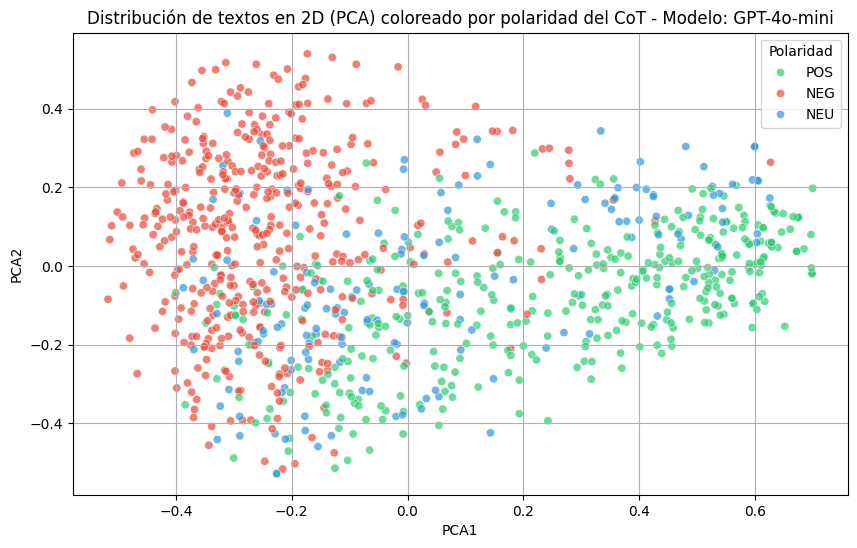

In [123]:
df_clusters = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": clusters,
    "Polaridad": polaridad  # del chain of thought
})

print("Distribución polaridad por cluster:")
print(pd.crosstab(df_clusters["Cluster"], df_clusters["Polaridad"]))


mapa_cluster_polaridad = {   #Visto a ojo en los clusters generados
    0: "POS",  
    1: "NEU",
    2: "NEG"
}
df_clusters["Polaridad_predicha"] = df_clusters["Cluster"].map(mapa_cluster_polaridad)

print(classification_report(df_clusters["Polaridad"], df_clusters["Polaridad_predicha"]))

paleta = {
    "POS": "#2ecc71",  
    "NEG": "#e74c3c", 
    "NEU": "#3498db"  
}
plt.figure(figsize=(10,6))
plt.grid(True)
sns.scatterplot(data=df_clusters, x="PCA1", y="PCA2", hue="Polaridad", palette=paleta, alpha=0.7)
plt.title(f"Distribución de textos en 2D (PCA) coloreado por polaridad del CoT - Modelo: {modelo[0]}")
plt.legend(title="Polaridad")
plt.show()



Distribución polaridad por cluster:
Polaridad  NEG  NEU  POS
Cluster                 
0           37   34  228
1          181   90  117
2          256   16    9
              precision    recall  f1-score   support

         NEG       0.91      0.54      0.68       474
         NEU       0.23      0.64      0.34       140
         POS       0.76      0.64      0.70       354

    accuracy                           0.59       968
   macro avg       0.64      0.61      0.57       968
weighted avg       0.76      0.59      0.64       968



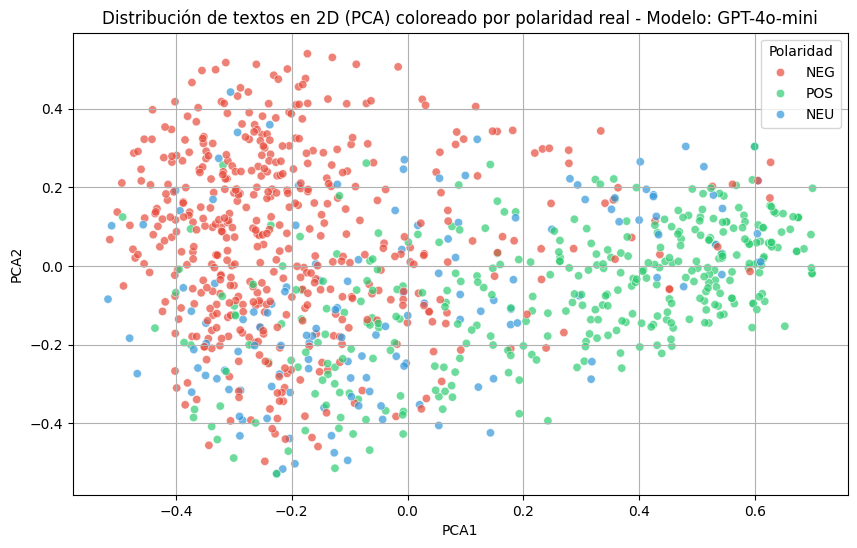

In [122]:
df_clusters = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "Cluster": clusters,
    "Polaridad": polaridad_True  # real
})

print("Distribución polaridad por cluster:")
print(pd.crosstab(df_clusters["Cluster"], df_clusters["Polaridad"]))


mapa_cluster_polaridad = {   #Visto a ojo en los clusters generados
    0: "POS",  
    1: "NEU",
    2: "NEG"
}
df_clusters["Polaridad_predicha"] = df_clusters["Cluster"].map(mapa_cluster_polaridad)

print(classification_report(df_clusters["Polaridad"], df_clusters["Polaridad_predicha"]))

paleta = {
    "POS": "#2ecc71",  
    "NEG": "#e74c3c", 
    "NEU": "#3498db"  
}
plt.figure(figsize=(10,6))
plt.grid(True)
sns.scatterplot(data=df_clusters, x="PCA1", y="PCA2", hue="Polaridad", palette=paleta, alpha=0.7)
plt.title(f"Distribución de textos en 2D (PCA) coloreado por polaridad real - Modelo: {modelo[0]}")
plt.legend(title="Polaridad")
plt.show()